# Imports

In [1]:
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, SentimentOptions
import json
import pandas as pd
import datetime
import pathlib
import time
import numpy as np
import statistics
import matplotlib.pyplot as plt

# Credentials and Authorization

In [4]:
with open("credentials.json", 'r') as jsonfile:
    credentials = json.load(jsonfile)['ibm-watson']

authenticator = IAMAuthenticator(credentials['api-key'])
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version=credentials['version'],
    authenticator=authenticator
)
natural_language_understanding.set_service_url(credentials['url'])

tweets_df = pd.read_csv(str(pathlib.Path().absolute()) + '\\datasets\\secondRound.csv')
tweets_df.head()

,Username,Created_at,Text
0,JoaoCampos,2020-11-27 22:47:12,vamo fazer recife avancar
1,JoaoCampos,2020-11-27 22:46:09,tamo junto
2,JoaoCampos,2020-11-27 22:43:21,rt ta chegando hora recife precisa continuar a...
3,JoaoCampos,2020-11-27 22:33:03,voce digita urnas confirma vamos construir mui...
4,JoaoCampos,2020-11-27 21:18:21,cenario pos pandemia desafiador precisamos pro...


# Sentiment Analysis

In [5]:
def analyseSentiment(text):
    response = natural_language_understanding.analyze(
    text=text,
    language = 'pt',
    features=Features(sentiment=SentimentOptions(document=True))).get_result()
    return (response['sentiment']['document']['label'],response['sentiment']['document']['score'])


In [8]:
label = []
score = []
for t in tweets_df.Text:
    result = analyseSentiment(t)
    label.append(result[0])
    score.append(result[1])
    
tweets_df['Label'] = label
tweets_df['Score'] = score

tweets_df.head()

,Username,Created_at,Text,Label,Score
0,JoaoCampos,2020-11-27 22:47:12,vamo fazer recife avancar,positive,0.479956
1,JoaoCampos,2020-11-27 22:46:09,tamo junto,positive,0.886086
2,JoaoCampos,2020-11-27 22:43:21,rt ta chegando hora recife precisa continuar a...,positive,0.891505
3,JoaoCampos,2020-11-27 22:33:03,voce digita urnas confirma vamos construir mui...,neutral,0.000000
4,JoaoCampos,2020-11-27 21:18:21,cenario pos pandemia desafiador precisamos pro...,negative,-0.500568


# Generate CSV - Second Round with Sentiment Analysis

In [9]:
tweets_df['Created_at'] = tweets_df['Created_at'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))
tweets_df.to_csv(str(pathlib.Path().absolute()) + '\\datasets\\secondRoundWithSA.csv', index=False)

# João Campos tweets

In [10]:
joaoCampos_tweets = tweets_df[tweets_df['Username'] == 'JoaoCampos']

# Datetime to Date
joaoCampos_tweets['Created_at'] = joaoCampos_tweets['Created_at'].apply(lambda d: d.date())

# Filter by Label
joaoCampos_tweets = joaoCampos_tweets[(joaoCampos_tweets.Label == 'positive') | (joaoCampos_tweets.Label == 'negative')]

joaoCampos_tweets.head()

<ipython-input-10-c17fccfeaf4c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joaoCampos_tweets['Created_at'] = joaoCampos_tweets['Created_at'].apply(lambda d: d.date())


,Username,Created_at,Text,Label,Score
0,JoaoCampos,2020-11-27,vamo fazer recife avancar,positive,0.479956
1,JoaoCampos,2020-11-27,tamo junto,positive,0.886086
2,JoaoCampos,2020-11-27,rt ta chegando hora recife precisa continuar a...,positive,0.891505
4,JoaoCampos,2020-11-27,cenario pos pandemia desafiador precisamos pro...,negative,-0.500568
7,JoaoCampos,2020-11-27,obrigado fazer parte desta caminhada propostas r,positive,0.839666


In [11]:
scorebyDate_jc = joaoCampos_tweets.groupby(by=['Created_at'])['Score'].apply(list).to_frame()

scorebyDate_jc['Positive'] = scorebyDate_jc['Score'].apply(lambda s: [score for score in s if score > 0])
scorebyDate_jc['Negative'] = scorebyDate_jc['Score'].apply(lambda s: [score for score in s if score < 0])

scorebyDate_jc['Positive quantity'] = scorebyDate_jc['Positive'].apply(lambda s: len(s))
scorebyDate_jc['Negative quantity'] = scorebyDate_jc['Negative'].apply(lambda s: len(s) * -1)

scorebyDate_jc['Positive mean'] = scorebyDate_jc['Positive'].apply(lambda s: 0 if s == [] else statistics.mean(s))
scorebyDate_jc['Negative mean'] = scorebyDate_jc['Negative'].apply(lambda s: 0 if s == [] else statistics.mean(s))

scorebyDate_jc.head()

,Score,Positive,Negative,Positive quantity,Negative quantity,Positive mean,Negative mean
Created_at,,,,,,,
2020-11-16,"[0.706929, 0.935005, 0.706929]","[0.706929, 0.935005, 0.706929]",[],3,0,0.782954,0.000000
2020-11-18,[0.856378],[0.856378],[],1,0,0.856378,0.000000
2020-11-19,"[-0.786025, -0.868275, 0.686636, -0.747732, -0...","[0.686636, 0.807233]","[-0.786025, -0.868275, -0.747732, -0.877922]",2,-4,0.746935,-0.819989
2020-11-20,"[0.650766, -0.361763, -0.609612, -0.862941, 0....","[0.650766, 0.425633, 0.639106, 0.460162]","[-0.361763, -0.609612, -0.862941, -0.632062, -...",4,-7,0.543917,-0.669514
2020-11-21,[-0.658573],[],[-0.658573],0,-1,0.000000,-0.658573


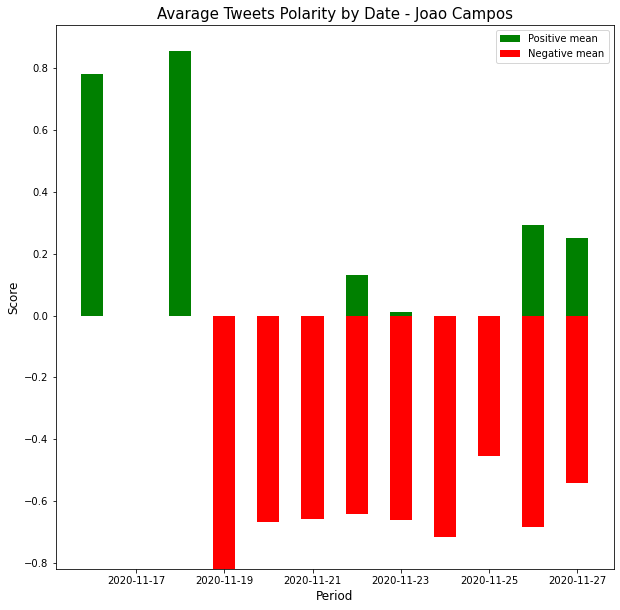

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_jc.index,scorebyDate_jc['Positive mean'], width, bottom=scorebyDate_jc['Negative mean'], color='g')
p2 = plt.bar(scorebyDate_jc.index,scorebyDate_jc['Negative mean'], width, color='r')

plt.title('Avarage Tweets Polarity by Date - Joao Campos',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive mean', 'Negative mean'),fontsize=10)

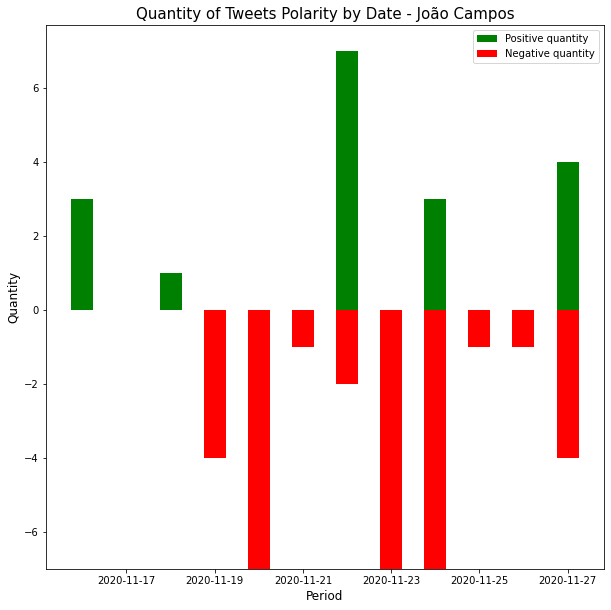

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_jc.index,scorebyDate_jc['Positive quantity'], width, bottom=scorebyDate_jc['Negative quantity'], color='g')
p2 = plt.bar(scorebyDate_jc.index,scorebyDate_jc['Negative quantity'], width, color='r')

plt.title('Quantity of Tweets Polarity by Date - João Campos',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Quantity',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive quantity', 'Negative quantity'),fontsize=10)

# Marília Arraes tweets

In [14]:
mariliaArraes_tweets = tweets_df[tweets_df['Username'] == 'MariliaArraes']

# Datetime to Date
mariliaArraes_tweets['Created_at'] = mariliaArraes_tweets['Created_at'].apply(lambda d: d.date())

# Filter by Label
mariliaArraes_tweets = mariliaArraes_tweets[(mariliaArraes_tweets.Label == 'positive') | (mariliaArraes_tweets.Label == 'negative')]

mariliaArraes_tweets.head()

<ipython-input-14-9474c8b21488>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mariliaArraes_tweets['Created_at'] = mariliaArraes_tweets['Created_at'].apply(lambda d: d.date())


,Username,Created_at,Text,Label,Score
137,MariliaArraes,2020-11-27,rt tum tum tum,positive,0.969534
138,MariliaArraes,2020-11-27,rt eleicao deste domingo pode melhorar cidade ...,negative,-0.411265
140,MariliaArraes,2020-11-27,gente ta chegando perto hora comemorar vitoria...,positive,0.908484
142,MariliaArraes,2020-11-27,tao lindo ver onda vermelha tomando cidade cad...,positive,0.824994
143,MariliaArraes,2020-11-27,ta certissimo,negative,-0.622446


In [15]:
scorebyDate_ma = mariliaArraes_tweets.groupby(by=['Created_at'])['Score'].apply(list).to_frame()

scorebyDate_ma['Positive'] = scorebyDate_ma['Score'].apply(lambda s: [score for score in s if score > 0])
scorebyDate_ma['Negative'] = scorebyDate_ma['Score'].apply(lambda s: [score for score in s if score < 0])

scorebyDate_ma['Positive quantity'] = scorebyDate_ma['Positive'].apply(lambda s: len(s))
scorebyDate_ma['Negative quantity'] = scorebyDate_ma['Negative'].apply(lambda s: len(s) * -1)

scorebyDate_ma['Positive mean'] = scorebyDate_ma['Positive'].apply(lambda s: 0 if s == [] else statistics.mean(s))
scorebyDate_ma['Negative mean'] = scorebyDate_ma['Negative'].apply(lambda s: 0 if s == [] else statistics.mean(s))

scorebyDate_ma.head()

,Score,Positive,Negative,Positive quantity,Negative quantity,Positive mean,Negative mean
Created_at,,,,,,,
2020-11-16,"[0.976949, 0.98758, 0.554383, -0.731641, 0.955...","[0.976949, 0.98758, 0.554383, 0.955336, 0.9493...",[-0.731641],7,-1,0.900899,-0.731641
2020-11-17,"[-0.801692, 0.659761, 0.403861, -0.812512, 0.4...","[0.659761, 0.403861, 0.457639, 0.81993, 0.479925]","[-0.801692, -0.812512, -0.812088]",5,-3,0.564223,-0.808764
2020-11-18,"[-0.320437, 0.324107, 0.863448, 0.567121, 0.61...","[0.324107, 0.863448, 0.567121, 0.616156, 0.946...","[-0.320437, -0.628981, -0.515415]",12,-3,0.756598,-0.488278
2020-11-19,"[-0.350014, 0.553961, 0.701563, -0.660733, 0.9...","[0.553961, 0.701563, 0.967534, 0.56177, 0.7934...","[-0.350014, -0.660733, -0.972019, -0.718565, -...",8,-8,0.746070,-0.650890
2020-11-20,"[0.819761, -0.749323, -0.713674, -0.807553, -0...","[0.819761, 0.845295, 0.793696, 0.521829, 0.936...","[-0.749323, -0.713674, -0.807553, -0.659167, -...",5,-15,0.783447,-0.766681


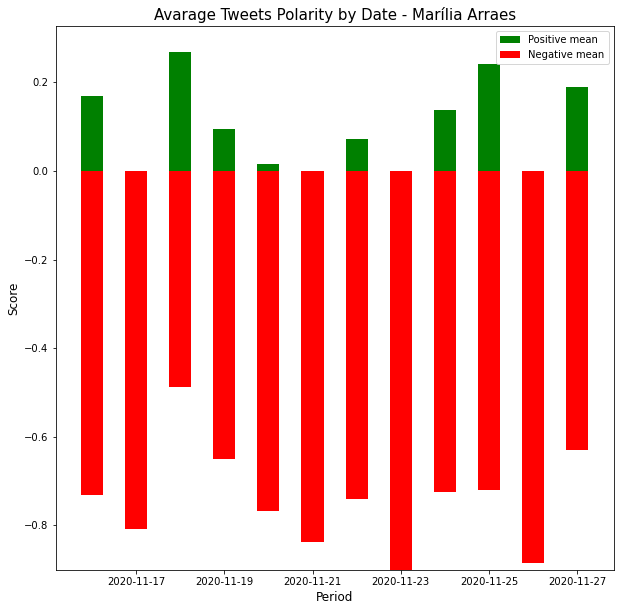

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_ma.index,scorebyDate_ma['Positive mean'], width, bottom=scorebyDate_ma['Negative mean'], color='g')
p2 = plt.bar(scorebyDate_ma.index,scorebyDate_ma['Negative mean'], width, color='r')

plt.title('Avarage Tweets Polarity by Date - Marília Arraes',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive mean', 'Negative mean'),fontsize=10)

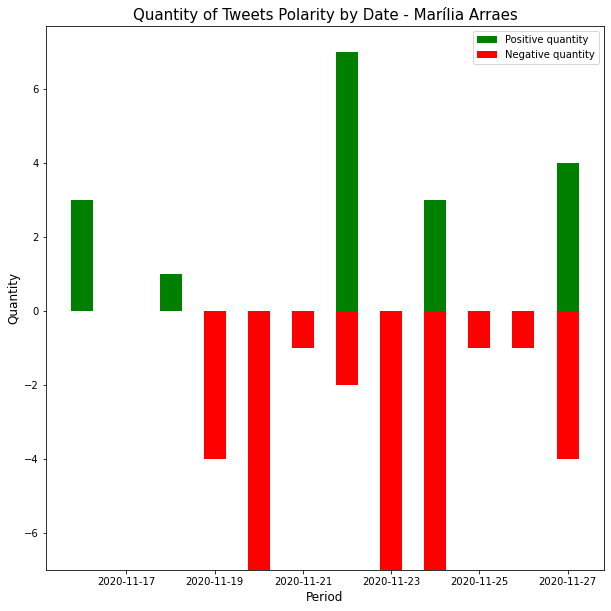

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
width = 0.50 

p1 = plt.bar(scorebyDate_jc.index,scorebyDate_jc['Positive quantity'], width, bottom=scorebyDate_jc['Negative quantity'], color='g')
p2 = plt.bar(scorebyDate_jc.index,scorebyDate_jc['Negative quantity'], width, color='r')

plt.title('Quantity of Tweets Polarity by Date - Marília Arraes',fontsize=15)
plt.xlabel('Period',fontsize=12)
plt.ylabel('Quantity',fontsize=12)
plt.legend((p1[0], p2[0]), ('Positive quantity', 'Negative quantity'),fontsize=10)